In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt

1.4.1.post1


## Loading the data

In [2]:
# weather data
weather = pd.read_csv('data/weather.csv')
weather.head()

,FID,the_geom,code,timestamp,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,...,wind_speed_unit,wind_direction,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness
0,synop_data.6407.2023-02-28 23:00:00+00,POINT (51.200341 2.887306),6407,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,50.0,4.0,NaN,NaN,1031.8,1031.2,NaN,NaN,1.0
1,synop_data.6418.2023-02-28 23:00:00+00,POINT (51.347375 3.201846),6418,2023-02-28T23:00:00,NaN,NaN,4.6,NaN,NaN,NaN,...,1,37.9,6.8,61.8,NaN,1031.9,1030.2,NaN,NaN,0.0
2,synop_data.6414.2023-02-28 23:00:00+00,POINT (50.90398 3.121692),6414,2023-02-28T23:00:00,NaN,NaN,-0.3,NaN,NaN,NaN,...,1,19.2,2.7,72.5,NaN,1031.9,1028.5,NaN,NaN,NaN
3,synop_data.6434.2023-02-28 23:00:00+00,POINT (50.980293 3.816003),6434,2023-02-28T23:00:00,NaN,NaN,-2.6,NaN,NaN,NaN,...,1,23.6,3.1,78.4,NaN,1031.5,1029.3,NaN,NaN,NaN
4,synop_data.6434.2023-03-01 00:00:00+00,POINT (50.980293 3.816003),6434,2023-03-01T00:00:00,0.0,1.0,-0.5,NaN,NaN,NaN,...,1,27.9,3.8,72.8,NaN,1031.7,1029.6,401.0,10335800.0,NaN


In [3]:
# sunrise-sunset data
sun = pd.read_excel('data/sunrise-sunset.xlsx')
sun.head()

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [4]:
# solar data
solar = pd.read_csv('data/solar.csv')
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,1.02
2,2023-03-11 18:00:10.284064+01,1.17
3,2023-03-11 19:00:10.224836+01,1.18
4,2023-03-11 20:00:10.201847+01,1.18


## Cleaning the data

In [5]:
# kwh is cummulative
# we need to calculate the daily kwh
solar["kwh"] = solar["kwh"] - solar["kwh"].shift(1, fill_value=0)
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,0.48
2,2023-03-11 18:00:10.284064+01,0.15
3,2023-03-11 19:00:10.224836+01,0.01
4,2023-03-11 20:00:10.201847+01,0.00


In [6]:
mean = solar["kwh"].mean()
std = solar["kwh"].std()
print(len(solar))
# remove outliers
solar = solar[abs(solar["kwh"] - mean) < std]
print(len(solar))
solar.describe()

7907
7904


,kwh
count,7904.000000
mean,0.243170
std,0.455937
min,0.000000
25%,0.000000
50%,0.000000
75%,0.238000
max,2.098000


In [7]:
# clean weather timestamp data
weather["timestamp"] = weather["timestamp"].apply(lambda date: pd.to_datetime(date).strftime("%Y-%m-%d %H"))
# split timestamp into date and hour
weather["date"] = weather["timestamp"].apply(lambda date: date.split(" ")[0])
weather["hour"] = weather["timestamp"].apply(lambda date: date.split(" ")[1])
weather.drop(columns=["timestamp"], inplace=True)
weather.head()

,FID,the_geom,code,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,wind_speed,...,wind_peak_speed,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness,date,hour
0,synop_data.6407.2023-02-28 23:00:00+00,POINT (51.200341 2.887306),6407,NaN,NaN,-0.3,NaN,NaN,NaN,3.000,...,4.0,NaN,NaN,1031.8,1031.2,NaN,NaN,1.0,2023-02-28,23
1,synop_data.6418.2023-02-28 23:00:00+00,POINT (51.347375 3.201846),6418,NaN,NaN,4.6,NaN,NaN,NaN,4.841,...,6.8,61.8,NaN,1031.9,1030.2,NaN,NaN,0.0,2023-02-28,23
2,synop_data.6414.2023-02-28 23:00:00+00,POINT (50.90398 3.121692),6414,NaN,NaN,-0.3,NaN,NaN,NaN,2.014,...,2.7,72.5,NaN,1031.9,1028.5,NaN,NaN,NaN,2023-02-28,23
3,synop_data.6434.2023-02-28 23:00:00+00,POINT (50.980293 3.816003),6434,NaN,NaN,-2.6,NaN,NaN,NaN,2.271,...,3.1,78.4,NaN,1031.5,1029.3,NaN,NaN,NaN,2023-02-28,23
4,synop_data.6434.2023-03-01 00:00:00+00,POINT (50.980293 3.816003),6434,0.0,1.0,-0.5,NaN,NaN,NaN,2.994,...,3.8,72.8,NaN,1031.7,1029.6,401.0,10335800.0,NaN,2023-03-01,00


In [8]:
# clean solar timestamp data
solar["timestamp"] = solar["timestamp"].apply(lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H"))
# split timestamp into date and huor
solar["date"] = solar["timestamp"].apply(lambda date: date.split(" ")[0])
solar["hour"] = solar["timestamp"].apply(lambda date: date.split(" ")[1])
solar.drop(columns=["timestamp"], inplace=True)
solar.head()

,kwh,date,hour
0,0.54,2023-03-11,16
1,0.48,2023-03-11,17
2,0.15,2023-03-11,18
3,0.01,2023-03-11,19
4,0.00,2023-03-11,20


In [9]:
sun.rename(columns={"datum": "date", "Opkomst": "sunrise", "Op ware middag": "sun_noon", "Ondergang": "sunset"}, inplace=True)
# make date column a string
sun["date"] = sun["date"].apply(lambda date: date.strftime("%Y-%m-%d"))
sun.head()

,date,sunrise,sun_noon,sunset
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [10]:
# merge all data
data = weather.merge(solar, on=["date", "hour"], how="inner").merge(sun, on=["date"], how="inner")
print(data.shape)

(31616, 26)


In [11]:
# convert date to datetime
data["date"] = data["date"].astype("datetime64")
# add month and day columns
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.dayofweek
# drop date column
data.drop("date", axis=1, inplace=True)
# convert hour to int
data["hour"] = data["hour"].astype("int")

## Date exploration

In [288]:
data.head()

,FID,the_geom,code,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,wind_speed,...,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness,hour,kwh,sunrise,sun_noon,sunset,month,day
0,synop_data.6434.2023-03-11 16:00:00+00,POINT (50.980293 3.816003),6434,NaN,NaN,6.8,NaN,NaN,NaN,1.329,...,NaN,NaN,NaN,16,0.54,07:06:00,12:53:00,18:40:00,3,5
1,synop_data.6414.2023-03-11 16:00:00+00,POINT (50.90398 3.121692),6414,NaN,NaN,7.0,NaN,NaN,NaN,1.369,...,NaN,NaN,NaN,16,0.54,07:06:00,12:53:00,18:40:00,3,5
2,synop_data.6418.2023-03-11 16:00:00+00,POINT (51.347375 3.201846),6418,NaN,NaN,5.6,NaN,NaN,NaN,2.516,...,NaN,NaN,NaN,16,0.54,07:06:00,12:53:00,18:40:00,3,5
3,synop_data.6407.2023-03-11 16:00:00+00,POINT (51.200341 2.887306),6407,NaN,NaN,5.8,NaN,NaN,NaN,2.000,...,NaN,NaN,7.0,16,0.54,07:06:00,12:53:00,18:40:00,3,5
4,synop_data.6414.2023-03-11 17:00:00+00,POINT (50.90398 3.121692),6414,NaN,NaN,6.7,NaN,NaN,NaN,1.786,...,NaN,NaN,NaN,17,0.48,07:06:00,12:53:00,18:40:00,3,5


In [289]:
data.tail()

,FID,the_geom,code,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,wind_speed,...,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness,hour,kwh,sunrise,sun_noon,sunset,month,day
31611,synop_data.6418.2024-02-04 10:00:00+00,POINT (51.347375 3.201846),6418,NaN,NaN,9.8,NaN,NaN,NaN,9.259,...,NaN,NaN,8.0,10,0.0997,08:15:00,12:56:00,17:39:00,2,6
31612,synop_data.6414.2024-02-04 11:00:00+00,POINT (50.90398 3.121692),6414,NaN,NaN,11.2,NaN,NaN,NaN,5.752,...,NaN,NaN,NaN,11,0.2391,08:15:00,12:56:00,17:39:00,2,6
31613,synop_data.6418.2024-02-04 11:00:00+00,POINT (51.347375 3.201846),6418,NaN,NaN,9.8,NaN,NaN,NaN,9.038,...,NaN,NaN,7.0,11,0.2391,08:15:00,12:56:00,17:39:00,2,6
31614,synop_data.6434.2024-02-04 11:00:00+00,POINT (50.980293 3.816003),6434,NaN,NaN,11.4,NaN,NaN,NaN,6.062,...,NaN,NaN,NaN,11,0.2391,08:15:00,12:56:00,17:39:00,2,6
31615,synop_data.6407.2024-02-04 11:00:00+00,POINT (51.200341 2.887306),6407,NaN,NaN,11.4,NaN,NaN,NaN,9.000,...,NaN,NaN,7.0,11,0.2391,08:15:00,12:56:00,17:39:00,2,6


In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31616 entries, 0 to 31615
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FID                          31616 non-null  object 
 1   the_geom                     31616 non-null  object 
 2   code                         31616 non-null  int64  
 3   precip_quantity              4906 non-null   float64
 4   precip_range                 5008 non-null   float64
 5   temp                         31616 non-null  float64
 6   temp_min                     1252 non-null   float64
 7   temp_max                     1253 non-null   float64
 8   temp_grass_min               936 non-null    float64
 9   wind_speed                   31603 non-null  float64
 10  wind_speed_unit              31616 non-null  int64  
 11  wind_direction               31236 non-null  float64
 12  wind_peak_speed              31595 non-null  float64
 13  humidity_relativ

In [291]:
data.describe()

,code,precip_quantity,precip_range,temp,temp_min,temp_max,temp_grass_min,wind_speed,wind_speed_unit,wind_direction,...,humidity_relative,weather_current,pressure,pressure_station_level,sun_duration_24hours,short_wave_from_sky_24hours,cloudiness,kwh,month,day
count,31616.000000,4906.000000,5008.000000,31616.000000,1252.000000,1253.000000,936.000000,31603.000000,31616.0,31236.000000,...,23712.000000,1987.000000,31604.000000,31616.000000,948.000000,6.320000e+02,11752.000000,31616.000000,31616.000000,31616.000000
mean,6418.250000,0.902711,1.498802,12.572637,9.490655,15.742458,6.959188,4.965828,1.0,188.822042,...,80.886901,36.897836,1013.897377,1012.054384,349.724684,1.131930e+07,5.355429,0.243170,7.004555,2.977227
std,9.909117,2.510817,0.500048,6.084236,5.137094,6.914885,5.321523,2.807223,0.0,93.239732,...,14.218035,26.557394,11.447304,11.457749,288.303671,8.502365e+06,2.539491,0.455916,3.325551,1.973473
min,6407.000000,0.000000,1.000000,-5.900000,-6.000000,-1.000000,-10.200000,0.000000,1.0,0.100000,...,24.700000,1.000000,965.100000,963.500000,0.000000,4.169000e+05,0.000000,0.000000,1.000000,0.000000
25%,6412.250000,0.000000,1.000000,8.600000,6.575000,10.800000,4.000000,2.952000,1.0,121.100000,...,72.400000,11.000000,1008.100000,1006.200000,77.750000,3.754300e+06,3.000000,0.000000,4.000000,1.000000
50%,6416.000000,0.000000,1.000000,12.100000,9.700000,14.800000,7.300000,4.497000,1.0,208.900000,...,84.300000,25.000000,1015.800000,1013.900000,310.000000,9.520900e+06,7.000000,0.000000,7.000000,3.000000
75%,6422.000000,0.400000,2.000000,16.900000,13.300000,21.200000,10.850000,6.635500,1.0,252.400000,...,91.900000,60.000000,1021.700000,1019.900000,588.000000,1.819400e+07,7.000000,0.238000,10.000000,5.000000
max,6434.000000,43.400000,2.000000,32.400000,23.000000,32.900000,20.500000,21.088000,1.0,360.000000,...,100.000000,100.000000,1041.800000,1040.400000,950.000000,2.943290e+07,8.000000,2.098000,12.000000,6.000000


In [12]:
data["the_geom"].value_counts()

POINT (50.980293 3.816003)    7904
POINT (50.90398 3.121692)     7904
POINT (51.347375 3.201846)    7904
POINT (51.200341 2.887306)    7904
Name: the_geom, dtype: int64

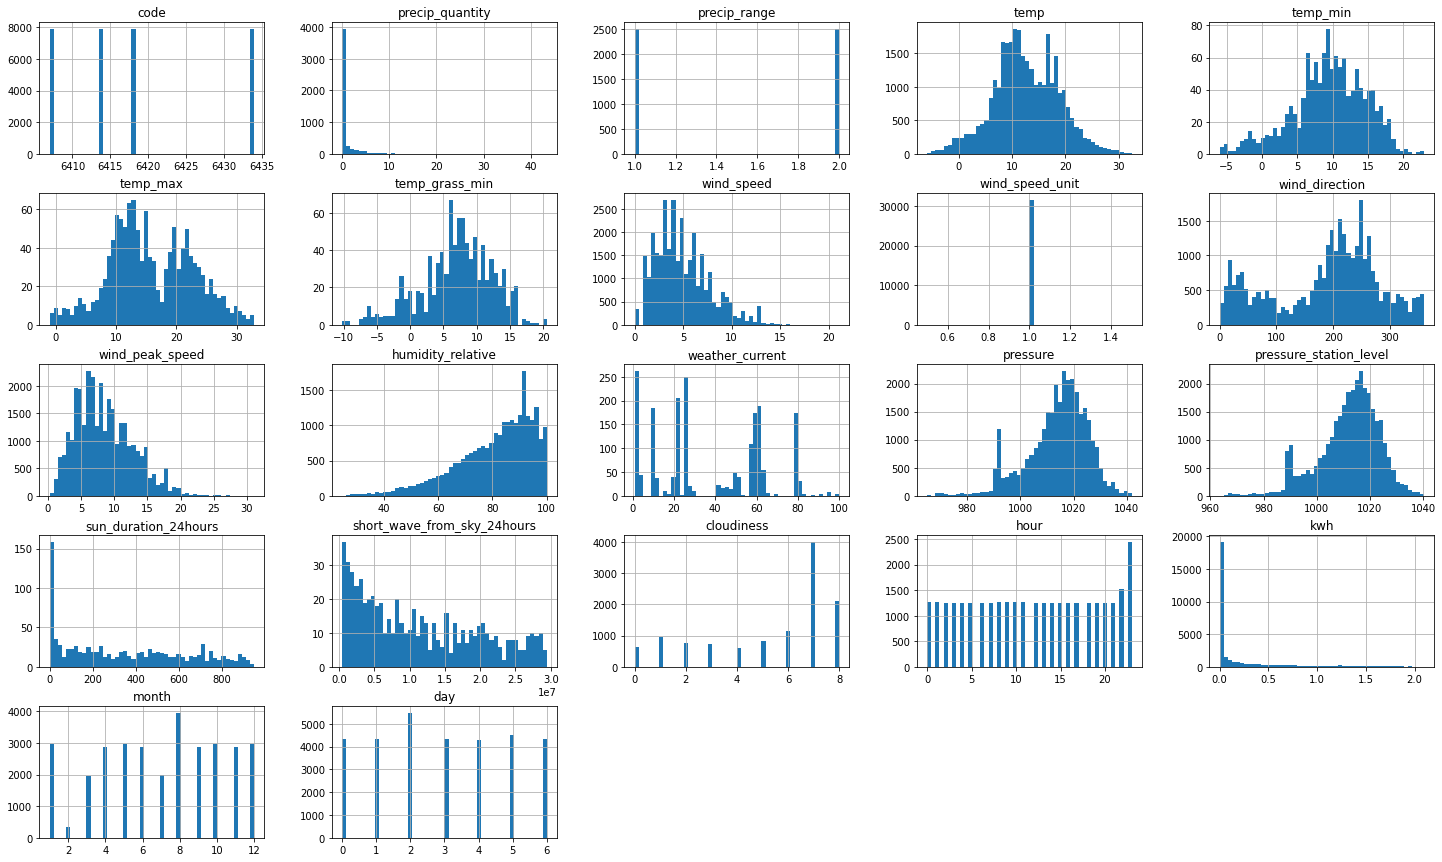

In [13]:
data.hist(bins=50, figsize=(25, 15))
plt.show()

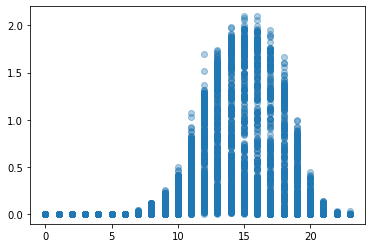

In [325]:
plt.scatter(data["hour"], data["kwh"], alpha=0.1);

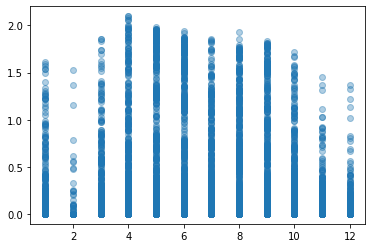

In [326]:
plt.scatter(data["month"], data["kwh"], alpha=0.1);

### Observations:
1. wind_speed_unit has only one value -> not usefull
2. code, precip_range and cloudiness are categroical
3. precip_ranges only two values
4. the_geom and code stand for the same thing
5. FID is code + timestamp
6. humidity_relative looks capped at 100
7. kwh has a heavy tail

In [14]:
# give categorical attributes the category type
data["code"] = data["code"].astype("category")
data["precip_range"] = data["precip_range"].astype("category")
data["cloudiness"] = data["cloudiness"].astype("category")
data["month"] = data["month"].astype("category")
data["day"] = data["day"].astype("category")
data["hour"] = data["hour"].astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31616 entries, 0 to 31615
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   FID                          31616 non-null  object  
 1   the_geom                     31616 non-null  object  
 2   code                         31616 non-null  category
 3   precip_quantity              4906 non-null   float64 
 4   precip_range                 5008 non-null   category
 5   temp                         31616 non-null  float64 
 6   temp_min                     1252 non-null   float64 
 7   temp_max                     1253 non-null   float64 
 8   temp_grass_min               936 non-null    float64 
 9   wind_speed                   31603 non-null  float64 
 10  wind_speed_unit              31616 non-null  int64   
 11  wind_direction               31236 non-null  float64 
 12  wind_peak_speed              31595 non-null  float64 
 13  h

## Create a test set

In [15]:
X = data.drop(columns=["kwh"])
y = data["kwh"]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(25292, 6324)

## Look for correlations

In [17]:
data = pd.concat([X_train, y_train], axis=1)

In [18]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["kwh"].sort_values(ascending=False).round(2)

kwh                            1.00
temp_max                       0.56
temp                           0.40
pressure_station_level         0.18
pressure                       0.18
short_wave_from_sky_24hours    0.12
sun_duration_24hours           0.05
temp_grass_min                 0.05
wind_peak_speed                0.04
wind_speed                     0.04
weather_current               -0.04
wind_direction                -0.10
precip_quantity               -0.17
humidity_relative             -0.63
temp_min                        NaN
wind_speed_unit                 NaN
Name: kwh, dtype: float64

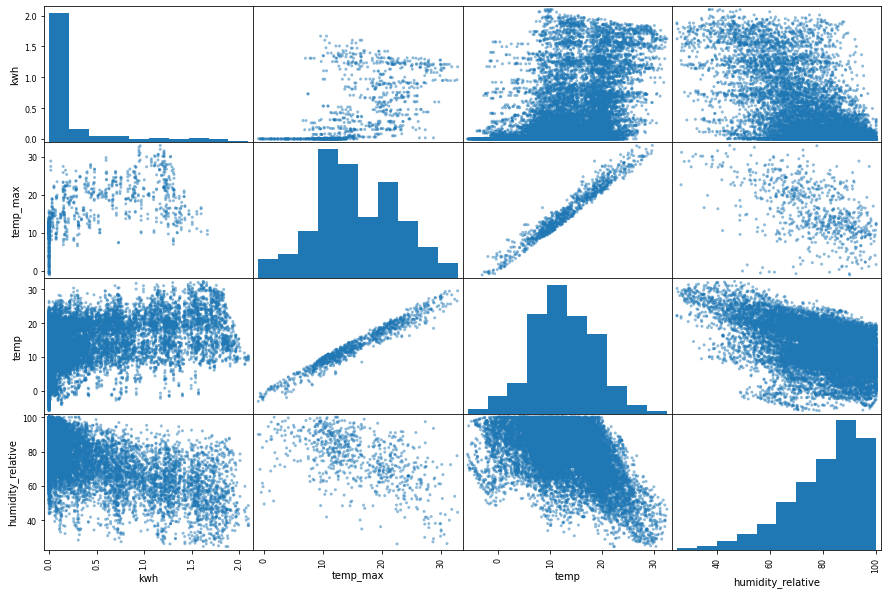

In [170]:
from pandas.plotting import scatter_matrix

attributes = ["kwh", "temp_max", "temp", "humidity_relative"]
scatter_matrix(data[attributes], figsize=(15, 10))
plt.show()

## Prepare the data

In [171]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25292 entries, 1807 to 23654
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   FID                          25292 non-null  object  
 1   the_geom                     25292 non-null  object  
 2   code                         25292 non-null  category
 3   precip_quantity              3896 non-null   float64 
 4   precip_range                 3977 non-null   category
 5   temp                         25292 non-null  float64 
 6   temp_min                     985 non-null    float64 
 7   temp_max                     991 non-null    float64 
 8   temp_grass_min               732 non-null    float64 
 9   wind_speed                   25280 non-null  float64 
 10  wind_speed_unit              25292 non-null  int64   
 11  wind_direction               24989 non-null  float64 
 12  wind_peak_speed              25274 non-null  float64 
 13

In [19]:
data_num = X_train.select_dtypes(include=[np.number])
data_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25292 entries, 1807 to 23654
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   precip_quantity              3896 non-null   float64
 1   temp                         25292 non-null  float64
 2   temp_min                     985 non-null    float64
 3   temp_max                     991 non-null    float64
 4   temp_grass_min               732 non-null    float64
 5   wind_speed                   25280 non-null  float64
 6   wind_speed_unit              25292 non-null  int64  
 7   wind_direction               24989 non-null  float64
 8   wind_peak_speed              25274 non-null  float64
 9   humidity_relative            18931 non-null  float64
 10  weather_current              1619 non-null   float64
 11  pressure                     25281 non-null  float64
 12  pressure_station_level       25292 non-null  float64
 13  sun_duration_

In [20]:
# get all categorical columns
data_cat = X_train.select_dtypes(include=["category"])
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25292 entries, 1807 to 23654
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   code          25292 non-null  category
 1   precip_range  3977 non-null   category
 2   cloudiness    9433 non-null   category
 3   hour          25292 non-null  category
 4   month         25292 non-null  category
 5   day           25292 non-null  category
dtypes: category(6)
memory usage: 347.9 KB


In [21]:
# get columns with more than 70% missing values
missing = data.isnull().sum() / len(data)
missing = missing[missing > 0.7].index.tolist()
missing

['precip_quantity',
 'precip_range',
 'temp_min',
 'temp_max',
 'temp_grass_min',
 'weather_current',
 'sun_duration_24hours',
 'short_wave_from_sky_24hours']

In [257]:
# work in progress
from sklearn.base import BaseEstimator, TransformerMixin

class EncodeDate(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        # X = check_array(X)
        return self

    def transform(self, X):
        assert "date" in self.feature_names_in_
        X = X.copy()
        X["date"] = pd.to_datetime(X["date"])
        X["month"] = X["date"].dt.month
        X["day"] = X["date"].dt.dayofweek
        X["month"] = X["month"].astype("category")
        X["day"] = X["day"].astype("category")
        X.drop("date", axis=1, inplace=True)
        return X

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

drop_attribs = ["FID", "the_geom", "wind_speed_unit"]
drop_attribs += missing
num_attirbs = [attrib for attrib in data_num.columns.values if attrib not in drop_attribs]
cat_attribs = [attrib for attrib in data_cat.columns.values if attrib not in drop_attribs]
# cat_attribs += ["month", "day"]
date_attribs = ["date"]

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

# log_pipeline = Pipeline([
#     ("impute", SimpleImputer(strategy="median")),
#     ("log", FunctionTransformer(np.log, inverse_func=np.exp)),
#     ("standardize", StandardScaler())
# ])

cat_pipline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")), 
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    # ("date", EncodeDate(), date_attribs),
    ("drop", "drop", drop_attribs),
    ("num", num_pipeline, num_attirbs),
    ("cat", cat_pipline, cat_attribs)
])

In [23]:
X_train_prepared = preprocessing.fit_transform(X_train)
X_train_prepared.shape

(25292, 63)

In [24]:
preprocessing.get_feature_names_out()

array(['num__temp', 'num__wind_speed', 'num__wind_direction',
       'num__wind_peak_speed', 'num__humidity_relative', 'num__pressure',
       'num__pressure_station_level', 'cat__code_6407.0',
       'cat__code_6414.0', 'cat__code_6418.0', 'cat__code_6434.0',
       'cat__cloudiness_0.0', 'cat__cloudiness_1.0',
       'cat__cloudiness_2.0', 'cat__cloudiness_3.0',
       'cat__cloudiness_4.0', 'cat__cloudiness_5.0',
       'cat__cloudiness_6.0', 'cat__cloudiness_7.0',
       'cat__cloudiness_8.0', 'cat__hour_0.0', 'cat__hour_1.0',
       'cat__hour_2.0', 'cat__hour_3.0', 'cat__hour_4.0', 'cat__hour_5.0',
       'cat__hour_6.0', 'cat__hour_7.0', 'cat__hour_8.0', 'cat__hour_9.0',
       'cat__hour_10.0', 'cat__hour_11.0', 'cat__hour_12.0',
       'cat__hour_13.0', 'cat__hour_14.0', 'cat__hour_15.0',
       'cat__hour_16.0', 'cat__hour_17.0', 'cat__hour_18.0',
       'cat__hour_19.0', 'cat__hour_20.0', 'cat__hour_21.0',
       'cat__hour_22.0', 'cat__hour_23.0', 'cat__month_1.0',
       '

In [25]:
X_train_prepared_df = pd.DataFrame(X_train_prepared.toarray(), columns=preprocessing.get_feature_names_out())
X_train_prepared_df.head()

,num__temp,num__wind_speed,num__wind_direction,num__wind_peak_speed,num__humidity_relative,num__pressure,num__pressure_station_level,cat__code_6407.0,cat__code_6414.0,cat__code_6418.0,...,cat__month_10.0,cat__month_11.0,cat__month_12.0,cat__day_0.0,cat__day_1.0,cat__day_2.0,cat__day_3.0,cat__day_4.0,cat__day_5.0,cat__day_6.0
0,0.088202,1.388606,0.473530,2.037763,-0.442472,-0.515297,-0.493310,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.090939,-0.528920,1.596320,-0.668433,-1.469152,0.375011,0.395505,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.170393,-1.054148,-1.286841,-0.831738,0.204256,1.151849,1.258179,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.289880,0.410792,-0.001954,0.894628,0.576124,-1.414333,-1.521548,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.455319,-0.228027,-1.133389,-0.365152,-3.102139,0.043328,0.038236,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

sqrt_transformer = FunctionTransformer(np.sqrt, inverse_func=np.square)

lin_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("lin_reg", TransformedTargetRegressor(LinearRegression(), transformer=sqrt_transformer))
])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('drop', 'drop',
                                                  ['FID', 'the_geom',
                                                   'wind_speed_unit',
                                                   'precip_quantity',
                                                   'precip_range', 'temp_min',
                                                   'temp_max', 'temp_grass_min',
                                                   'weather_current',
                                                   'sun_duration_24hours',
                                                   'short_wave_from_sky_24hours']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   Standar...
                                                   'pressure_station_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['code', 'cloudiness', 'hour',
                                                   'month', 'day'])])),
                ('lin_reg',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                            inverse_func=<ufunc 'square'>)))])

In [ ]:
# cross validation for linear regression
from sklearn.model_selection import cross_val_score

lin_reg_rmses = -cross_val_score(lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_reg_rmses).describe()

In [ ]:
from sklearn.metrics import root_mean_squared_error

y_test_pred = lin_reg.predict(X_test)

rmse = root_mean_squared_error(y_test, y_test_pred)
rmse

In [69]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("forest_reg", TransformedTargetRegressor(RandomForestRegressor(random_state=42), transformer=sqrt_transformer))
])

forest_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('drop', 'drop',
                                                  ['FID', 'the_geom',
                                                   'wind_speed_unit',
                                                   'precip_quantity',
                                                   'precip_range', 'temp_min',
                                                   'temp_max', 'temp_grass_min',
                                                   'weather_current',
                                                   'sun_duration_24hours',
                                                   'short_wave_from_sky_24hours']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   Standar...
                                                   'pressure_station_level']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['code', 'cloudiness', 'hour',
                                                   'month', 'day'])])),
                ('forest_reg',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42),
                                            transformer=FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                            inverse_func=<ufunc 'square'>)))])

In [71]:
# cross validation for random forest
scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
-scores.mean()

0.17079051001846876

In [72]:
y_test_pred = forest_reg.predict(X_test)

rmse = root_mean_squared_error(y_test, y_test_pred)
rmse

0.16788584457836075